Episode 5000/5000
Recent Stats (last 500):
Win: 85.4%  Loss: 8.6%  Draw: 6.0%
Q-table Size: 625  Exploration: 0.10
Elapsed Time: 1.7s



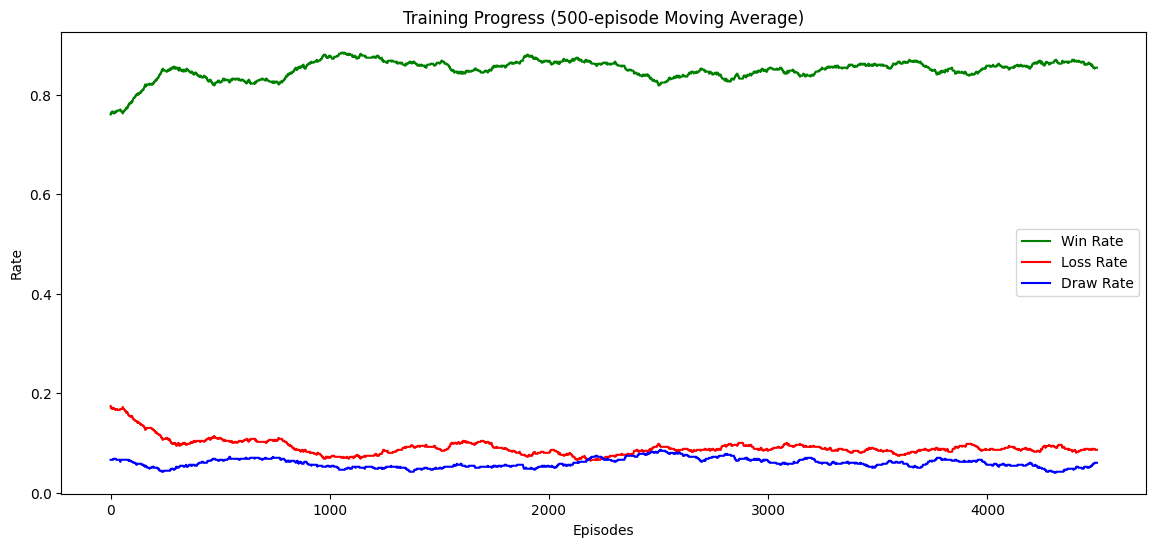


New Game! AI plays as X

Current Board:
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | 8 


AI's turn...
AI chose position 8

Current Board:
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | X 

Your turn (0-8): 0

Current Board:
 O | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | X 


AI's turn...
AI chose position 6

Current Board:
 O | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 X | 7 | X 

Your turn (0-8): 1

Current Board:
 O | O | 2 
-----------
 3 | 4 | 5 
-----------
 X | 7 | X 


AI's turn...
AI chose position 2

Current Board:
 O | O | X 
-----------
 3 | 4 | 5 
-----------
 X | 7 | X 

Your turn (0-8): 4

Current Board:
 O | O | X 
-----------
 3 | O | 5 
-----------
 X | 7 | X 


AI's turn...
AI chose position 3

Current Board:
 O | O | X 
-----------
 X | O | 5 
-----------
 X | 7 | X 

Your turn (0-8): 5

Current Board:
 O | O | X 
-----------
 X | O | O 
-----------
 X | 7 | X 


AI's turn...
AI chose position 7

Current Board:
 O | O | X 
--------

In [12]:
import numpy as np
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

class TicTacToe:
    def __init__(self):
        self.board = [' '] * 9
        self.current_player = 'X'
        self.game_over = False
        self.winner = None
        self.win_lines = [(0,1,2),(3,4,5),(6,7,8),
                         (0,3,6),(1,4,7),(2,5,8),
                         (0,4,8),(2,4,6)]

    def reset(self):
        self.__init__()
        return self.normalize_state(tuple(self.board))

    def normalize_state(self, state):
        """合并对称状态（4种旋转+镜像）"""
        rotations = [
            state,
            (state[6], state[3], state[0], state[7], state[4], state[1], state[8], state[5], state[2]),
            (state[8], state[7], state[6], state[5], state[4], state[3], state[2], state[1], state[0]),
            (state[2], state[5], state[8], state[1], state[4], state[7], state[0], state[3], state[6]),
        ]
        mirrors = [
            (state[2], state[1], state[0], state[5], state[4], state[3], state[8], state[7], state[6]),
            (state[6], state[7], state[8], state[3], state[4], state[5], state[0], state[1], state[2]),
        ]
        all_states = rotations + mirrors
        return min(all_states)

    def render(self):
        print("\nCurrent Board:")
        for i in range(0, 9, 3):
            row = [str(i+j) if self.board[i+j] == ' ' else self.board[i+j]
                  for j in range(3)]
            print(f" {row[0]} | {row[1]} | {row[2]} ")
            if i < 6:
                print("-----------")
        print()

    def available_actions(self):
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def check_winner(self):
        for a, b, c in self.win_lines:
            if self.board[a] == self.board[b] == self.board[c] != ' ':
                return self.board[a]
        return None

    def step(self, action):
        # 处理无效动作
        if self.board[action] != ' ':
            self.game_over = True
            self.winner = 'O'  # 标记对手获胜
            return self.normalize_state(tuple(self.board)), -10, True, {}

        self.board[action] = self.current_player
        winner = self.check_winner()

        reward = 0
        if winner:
            reward = 15 if winner == 'X' else -10
            self.winner = winner
            self.game_over = True
        elif ' ' not in self.board:
            reward = -1
            self.game_over = True
        else:
            # 战略位置奖励
            reward = 0.5 if action == 4 else (0.3 if action in [0,2,6,8] else 0.1)
            self.current_player = 'O' if self.current_player == 'X' else 'X'

        return self.normalize_state(tuple(self.board)), reward, self.game_over, {}

class QAgent:
    def __init__(self, lr=0.15, gamma=0.9, eps=0.7, eps_min=0.1, eps_decay=0.997):
        self.q_table = {}
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay

    def get_action(self, state, actions, training=True):
        # 保留测试阶段探索率
        if not training and random.random() < 0.05:
            return self._priority_choice(actions)

        if training and random.random() < self.eps:
            return self._priority_choice(actions)

        # 使用Softmax选择增加多样性
        q_vals = np.array([self.q_table.get((state, a), 0) for a in actions])
        if np.all(q_vals == 0):
            return random.choice(actions)
        probs = np.exp(q_vals - np.max(q_vals)) / np.sum(np.exp(q_vals - np.max(q_vals)))  # 数值稳定处理
        return np.random.choice(actions, p=probs)

    def _priority_choice(self, actions):
        """优先选择策略：中心 > 角落 > 边缘"""
        if 4 in actions: return 4
        for corner in [0, 2, 6, 8]:
            if corner in actions: return corner
        return random.choice(actions)

    def update(self, state, action, reward, next_state, done):
        old_q = self.q_table.get((state, action), 0)
        if done:
            new_q = old_q + self.lr * (reward - old_q)
        else:
            valid_actions = [i for i, s in enumerate(next_state) if s == ' ']
            future_max = max([self.q_table.get((next_state, a), 0) for a in valid_actions]) if valid_actions else 0
            new_q = old_q + self.lr * (reward + self.gamma * future_max - old_q)

        self.q_table[(state, action)] = new_q
        self.eps = max(self.eps_min, self.eps * self.eps_decay)

def train(episodes=5000):
    env = TicTacToe()
    agent = QAgent()
    history = {'wins': [], 'losses': [], 'draws': []}

    print("Training started...")
    start_time = time.time()

    for ep in range(episodes):
        state = env.reset()
        done = False

        while not done:
            actions = env.available_actions()
            if not actions: break

            action = agent.get_action(state, actions, training=True)
            next_state, reward, done, _ = env.step(action)

            # 对手随机动作
            if not done:
                opp_action = random.choice(env.available_actions())
                _, _, done, _ = env.step(opp_action)

            agent.update(state, action, reward, next_state, done)
            state = next_state

        # 记录每个回合的结果
        history['wins'].append(1 if env.winner == 'X' else 0)
        history['losses'].append(1 if env.winner == 'O' else 0)
        history['draws'].append(1 if env.winner is None else 0)

        # 进度报告
        if ep % 500 == 0 or ep == episodes-1:
            window_size = 500
            start_idx = max(0, len(history['wins'])-window_size)

            wr = np.mean(history['wins'][start_idx:])
            lr = np.mean(history['losses'][start_idx:])
            dr = np.mean(history['draws'][start_idx:])

            clear_output(wait=True)
            print(f"Episode {ep+1}/{episodes}")
            print(f"Recent Stats (last {window_size}):")
            print(f"Win: {wr:.1%}  Loss: {lr:.1%}  Draw: {dr:.1%}")  # 添加此行
            print(f"Q-table Size: {len(agent.q_table)}  Exploration: {agent.eps:.2f}")
            print(f"Elapsed Time: {time.time()-start_time:.1f}s\n")

    # 绘制训练曲线（使用移动平均）
    plt.figure(figsize=(14, 6))
    window_size = 500
    wins_ma = np.convolve(history['wins'], np.ones(window_size)/window_size, mode='valid')
    losses_ma = np.convolve(history['losses'], np.ones(window_size)/window_size, mode='valid')
    draws_ma = np.convolve(history['draws'], np.ones(window_size)/window_size, mode='valid')

    plt.plot(wins_ma, label='Win Rate', color='green')
    plt.plot(losses_ma, label='Loss Rate', color='red')
    plt.plot(draws_ma, label='Draw Rate', color='blue')

    plt.title(f"Training Progress ({window_size}-episode Moving Average)")
    plt.xlabel("Episodes")
    plt.ylabel("Rate")
    plt.legend()
    plt.show()

    return agent

def play(agent):
    env = TicTacToe()
    state = env.reset()

    print("\nNew Game! AI plays as X")
    env.render()

    while not env.game_over:
        if env.current_player == 'X':
            print("\nAI's turn...")
            time.sleep(0.5)
            action = agent.get_action(state, env.available_actions(), training=False)
            print(f"AI chose position {action}")
        else:
            while True:
                try:
                    action = int(input("Your turn (0-8): "))
                    if action in env.available_actions():
                        break
                    print(f"Invalid! Available: {env.available_actions()}")
                except:
                    print("Please enter 0-8")

        state, _, done, _ = env.step(action)
        env.render()

        if env.winner:
            print(f"Game Over! {'AI' if env.winner == 'X' else 'You'} won!")
        elif done:
            print("It's a draw!")

    return input("Play again? (y/n) ").lower().startswith('y')

if __name__ == "__main__":
    ai = train(episodes=5000)
    while True:
        if not play(ai):
            print("Thanks for playing!")
            break